## ${\textbf{Libraries}}$

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle

## ${\textbf{Import Data}}$

In [2]:
df_segmentation = pd.read_csv('customer data.csv', index_col = 0)

## ${\textbf{Exploratory Data Analysis}}$

In [3]:
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [4]:
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


## ${\textbf{Correlation Estimate}}$

In [5]:
# Compute Pearson correlation coefficient for the features in the data set.
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


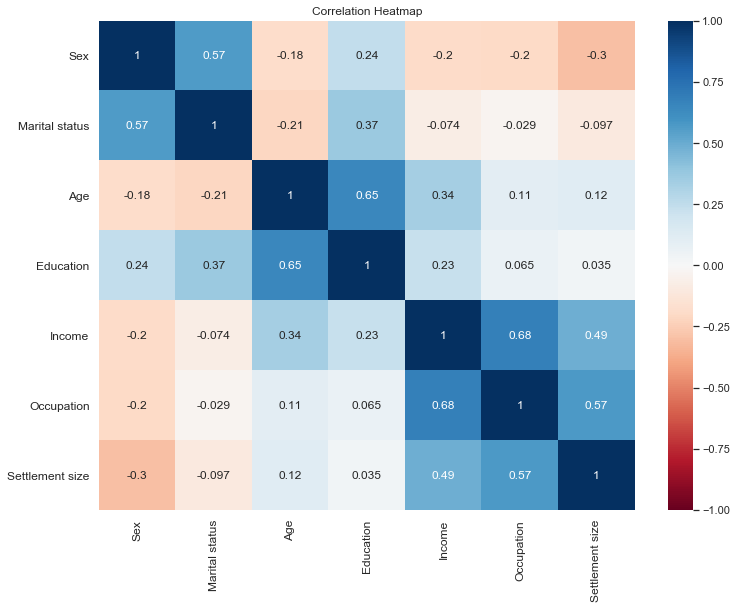

In [6]:
# We'll plot the correlations using a Heat Map. Heat Maps are a great way to visualize correlations using color coding.
# We use RdBu as a color scheme, but you can use viridis, Blues, YlGnBu or many others.
# We set the range from -1 to 1, as it is the range of the Pearson Correlation. 
# Otherwise the function infers the boundaries from the input.
# In this case they will be -0,25 to 0,68, as they are the minumum and maximum correlation indeces between our features.
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_segmentation.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

## ${\textbf{Visualize Raw Data}}$

Text(0.5, 1.0, 'Visualization of raw data')

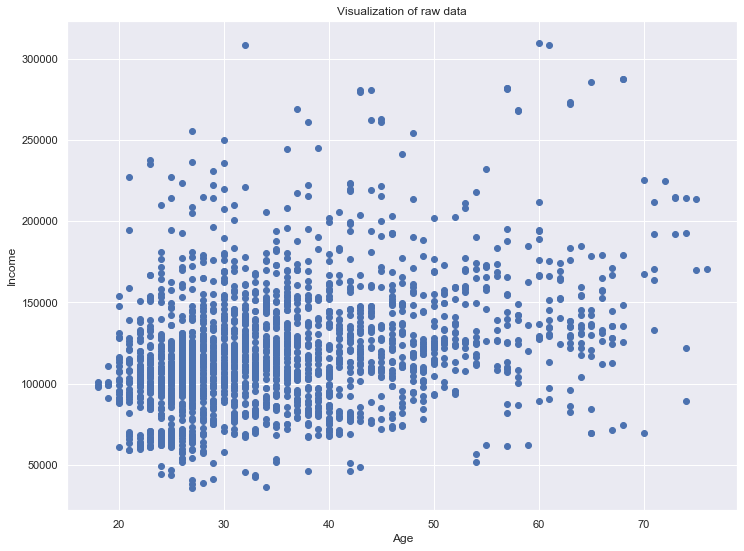

In [7]:
plt.figure(figsize = (12, 9))
plt.scatter(df_segmentation.iloc[:, 2], df_segmentation.iloc[:, 4])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Visualization of raw data')

## ${\textbf{Standardization}}$

In [8]:
# Standardizing data, so that all features have equal weight. This is important for modelling.
# Otherwise, in our case Income would be considered much more important than Education for Instance. 
# We do not know if this is the case, so we would not like to introduce it to our model. 
# This is what is also refered to as bias.
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

In [9]:
df_segmentation_std = pd.DataFrame(data=segmentation_std) 

In [10]:
df_segmentation_std.columns = df_segmentation.columns

In [11]:
df_segmentation_std.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298


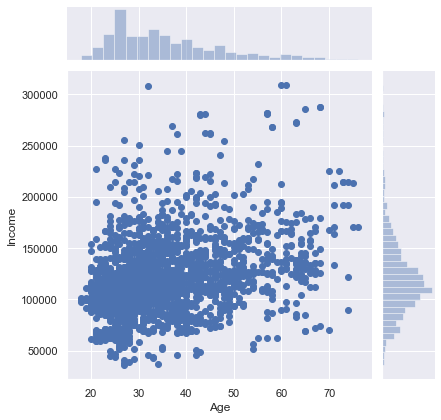

In [12]:
# Before standization
sns.jointplot(x='Age',y='Income',data=df_segmentation,kind='scatter')

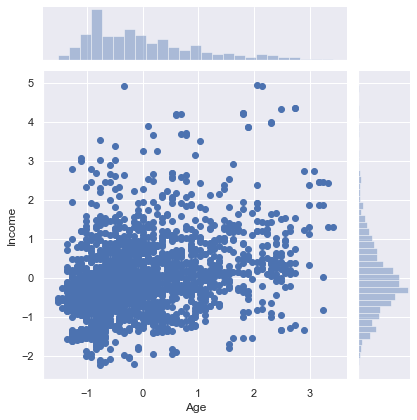

In [13]:
# After standization
sns.jointplot(x='Age',y='Income',data=df_segmentation_std,kind='scatter')

## ${\textbf{K-means Clustering}}$

In [14]:
# Perform K-means clustering. We consider 1 to 10 clusters, so our for loop runs 10 iterations.
# In addition we run the algortihm at many different starting points - k means plus plus. 
# And we set a random state for reproducibility.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

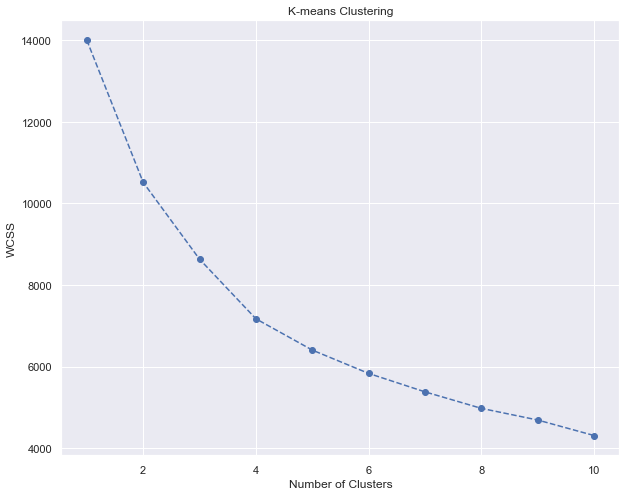

In [15]:
# Plot the Within Cluster Sum of Squares for the different number of clusters.
# From this plot we choose the number of clusters. 
# We look for a kink in the graphic, after which the descent of wcss isn't as pronounced.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [16]:
# We run K-means with a fixed number of clusters. In our case 4.
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [17]:
# We divide our data into the four clusters.
kmeans.fit(segmentation_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### ${\textbf{Results}}$

In [18]:
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [19]:
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


In [20]:
# Compute the size and proportions of the four clusters
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [21]:
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [22]:
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'career focused',
                         3:'standard'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
career focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [49]:
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'well-off', 
                                                                  1:'fewer opportunities',
                                                                  2:'career focused', 
                                                                  3:'standard'})

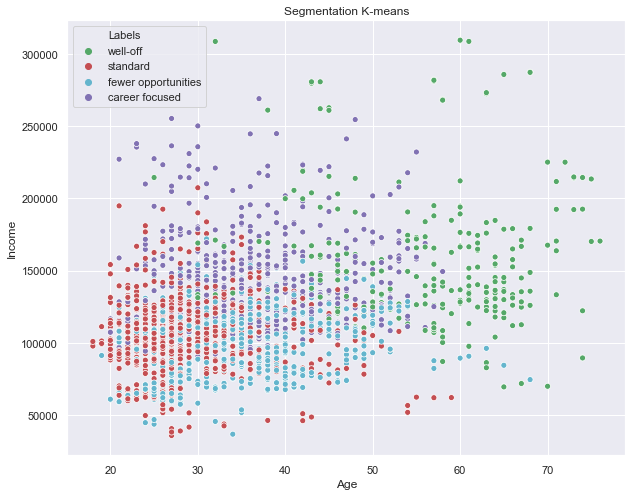

In [50]:
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

### ${\textbf{PCA}}$

In [51]:
pca = PCA()

In [52]:
# Fit PCA with the standardized data.
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [53]:
# The attribute shows how much variance is explained by each of the seven individual components.
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Text(0, 0.5, 'Cumulative Explained Variance')

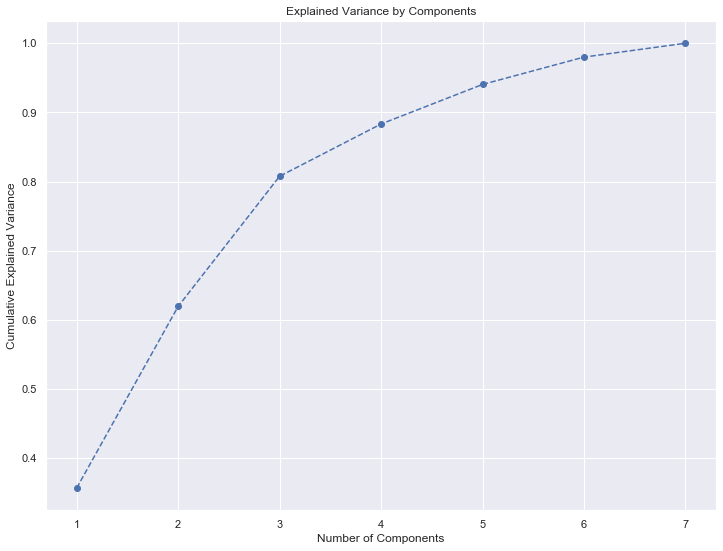

In [54]:
# Plot the cumulative variance explained by total number of components.
# On this graph we choose the subset of components we want to keep. 
# Generally, we want to keep around 80 % of the explained variance.
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [55]:
pca = PCA(n_components = 3)

In [56]:
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### ${\textbf{PCA Results}}$

In [57]:
# The components attribute shows the loadings of each component on each of the seven original features.
# The loadings are the correlations between the components and the original features. 
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [58]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp
# The closer a result is to 0, the lower the loading of a variable onto a component

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


([<matplotlib.axis.YTick at 0x7f8cea384310>,
 <a list of 3 Text yticklabel objects>)

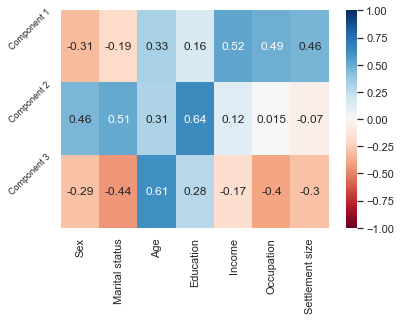

In [59]:
# Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)

In [60]:
pca.transform(segmentation_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [61]:
scores_pca = pca.transform(segmentation_std)

### ${\textbf{K-means clustering with PCA}}$

In [62]:
# Fit K means using the transformed data from the PCA, PCA scores
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

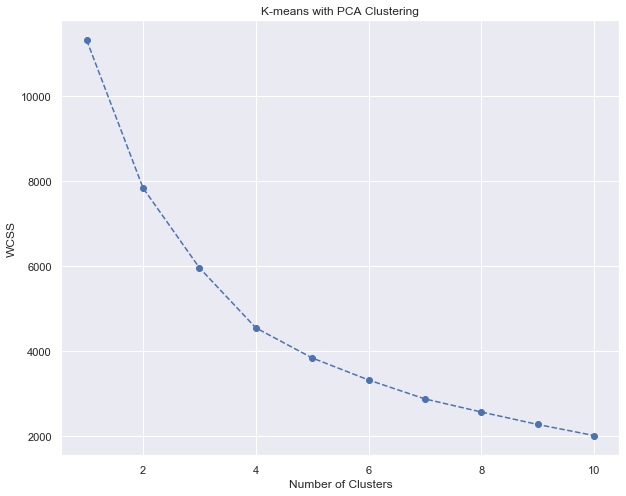

In [63]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decision about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [64]:
# We have chosen four clusters, so we run K-means with number of clusters equals four. 
# Same initializer and random state as before.
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [65]:
# We fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### ${\textbf{K-means clustering with PCA Results}}$

In [73]:
# Create a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
# The last column we add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [74]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,2
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,1
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,3
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,3
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,1
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,2
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,1
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,2


In [77]:
# Calculate the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953
1,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493
2,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925
3,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046


In [78]:
# Calculate the size of each cluster and its proportion to the entire data set.
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'well-off', 
                                                          1:'fewer opportunities',
                                                          2:'standard', 
                                                          3:'career focused'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
well-off,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,264,0.1320
fewer opportunities,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493,459,0.2295
standard,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925,694,0.3470
career focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915


In [81]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'well-off', 
                                                          1:'fewer opportunities',
                                                          2:'standard', 
                                                          3:'career focused'})

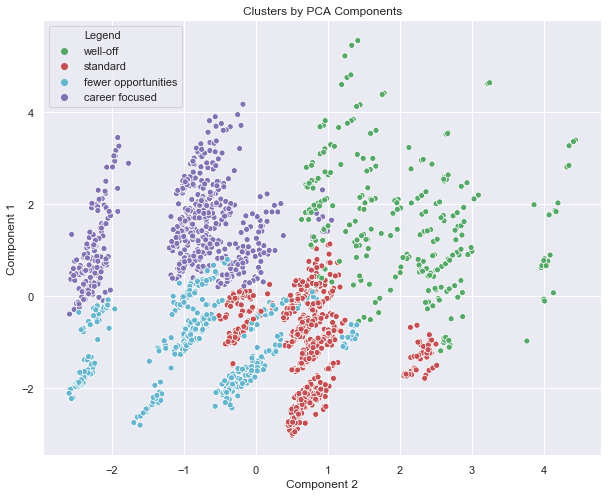

In [82]:
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

### ${\textbf{Data Export}}$

In [83]:
pickle.dump(scaler, open('scaler.pickle', 'wb'))

In [84]:
pickle.dump(pca, open('pca.pickle', 'wb'))

In [85]:
pickle.dump(kmeans_pca, open('kmeans_pca.pickle', 'wb'))